In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from sklearn.linear_model import LogisticRegression

**Note**: on this notebook I am just practicing concepts of multiple linear regression. I am not considering some aspects related to machine learning like the imputation of missing values or the normalisation of the predictor variables. 

## Loading and processing the data

The dataset used in this notebook is an example dataset about accessing graduate school which was obtained from https://stats.idre.ucla.edu/r/dae/logit-regression/. The `admit` column corresponds to the two-level categorical response variable. The variables containing the `gre` and `gpa` scores of the candidate are numerical, whereas the variable `rank`, that indicates the prestige of the school, is categorical. 

In [9]:
df = pd.read_csv('data/binary.csv')
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Building indicator variables to replace the rank categorical variable:

In [11]:
values = np.unique(df['rank'])[0:-1]
for v in values:
    df['rank_' + str(v)] = (df['rank'] == v).astype(int)
del df['rank']
df.head()

,admit,gre,gpa,rank_1,rank_2,rank_3
0,0,380,3.61,0,0,1
1,1,660,3.67,0,0,1
2,1,800,4.00,1,0,0
3,1,640,3.19,0,0,0
4,0,520,2.93,0,0,0


## Logistic regression

Logistic regression is a type of generalised linear model in which the response variable is a two-level categorical variable that, for each observation, takes the value Yi = 1 with probability pi and the value Yi = 0 with probability Yi = 0.

A generalised linear model is a generalisation of linear regression in which the residuals can be non-normally distributed. This is achieved by linking the response variable to a multiple regression model by means of a transformation variable, usually the logit function:

Text(0,0.5,'logit')

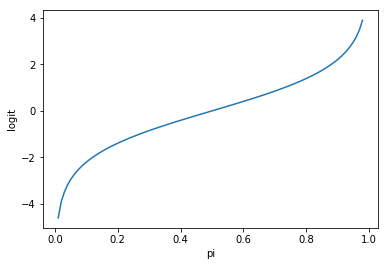

In [12]:
fig, ax = plt.subplots()
p = np.arange(0.01, 0.99, 0.01)
logit = np.log(p/(1-p))
ax.plot(p, logit)
ax.set_xlabel('pi')
ax.set_ylabel('logit')

In order to fit a linear regression model a function based on Newton method for numerical optimisation is commonly used:

In [14]:
lg = LogisticRegression()
lg.fit(df[['gre', 'gpa', 'rank_1', 'rank_2', 'rank_3']], df['admit'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
lg.score(df[['gre', 'gpa', 'rank_1','rank_2', 'rank_3']], df['admit'])

0.7

In [6]:
lg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}